In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.t8btag_minmass

In [3]:
signal = ObjIter([Tree(f, report=False) for f in tqdm(module.signal_list)])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List)])

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


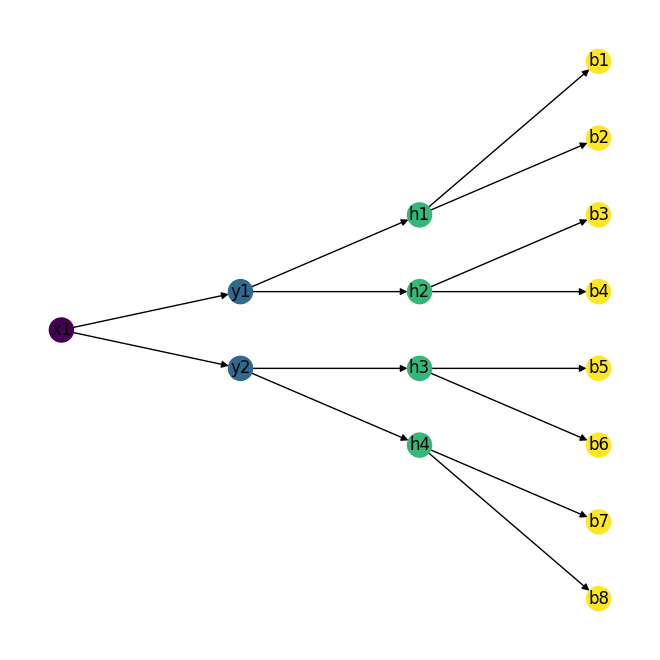

In [4]:
from utils.FeynNet.Feynman import Feynman

x_yy_4h_8b = Feynman('x').decays(
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    ),
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    )
).build_diagram()
x_yy_4h_8b.draw_diagram()

In [5]:
internalstates = x_yy_4h_8b.get_internalstate_types()

jet_perms = x_yy_4h_8b.get_finalstate_permutations(b=8)['b']
h_b_perms = internalstates['h'][0].get_product_permutations(b=8)['b']
y_h_perms = internalstates['y'][0].get_product_permutations(b=8)['h']
x_y_perms = internalstates['x'][0].get_product_permutations(b=8)['y']

In [6]:
def get_reco(jet_p4, perm):
    p4 = jet_p4[perm]

    h_p4 = p4[:,::2] + p4[:,1::2]
    y_p4 = h_p4[:,::2] + h_p4[:,1::2]
    x_p4 = y_p4[:,0] + y_p4[:,1]

    y_rank = ak_rank( y_p4.pt, axis=1 )
    x_yy_order = ak.argsort(y_rank, ascending=True)

    y_h_rank = ak.unflatten(
            np.repeat(y_rank, 2),
            ak.count(h_p4.pt,axis=1),
        )
    h_rank = ak_rank( h_p4.pt, axis=1 )
    x_yy_4h_order = ak.argsort( 10*y_h_rank + h_rank, ascending=True )

    y_h_j_rank = ak.unflatten(
            np.repeat(y_h_rank, 2),
            ak.count(p4.pt,axis=1),
        )
    j_rank = ak_rank(p4.pt, axis=1)
    x_yy_4h_8b_order = ak.argsort( 100*y_h_j_rank + j_rank, ascending=True)

    y_p4_ordered = y_p4[x_yy_order]
    h_p4_ordered = h_p4[x_yy_4h_order]
    j_p4_ordered = p4[x_yy_4h_8b_order]
    

    return x_p4, y_p4_ordered, h_p4_ordered, j_p4_ordered

In [7]:
def get_best_perm(jet_p4):
    b_perms = jet_p4[:,h_b_perms]
    h_p4 = b_perms[:,:,0] + b_perms[:,:,1]
    h_perms = h_p4[:,y_h_perms]
    y_p4 = h_perms[:,:,0] + h_perms[:,:,1]
    y_perms = y_p4[:,x_y_perms]
    x_p4 = y_perms[:,:,0] + y_perms[:,:,1]
    x_4h_m = ak.flatten(h_perms.m[:,x_y_perms], axis=3)
    x_2y_m = y_perms.m
    x_m = x_p4.m
    # m_chi2 = (x_m/1000-1)**2 + ak.mean( (x_2y_m/450 - 1)**2, axis=2) + ak.mean( (x_4h_m/125 - 1)**2, axis=2)
    # m_chi2 = ak.mean( (x_2y_m/450 - 1)**2, axis=2) + ak.mean( (x_4h_m/125 - 1)**2, axis=2)
    m_chi2 = ( (x_2y_m[:,:,0] - x_2y_m[:,:,1])/(x_2y_m[:,:,0] + x_2y_m[:,:,1]) )**2 + ak.sum( (x_4h_m/125 - 1)**2, axis=2)

    reco_rank = ak.min(m_chi2, axis=1)
    best_perms = jet_perms[ak.argmin( m_chi2, axis=1)]

    return ak.from_regular(best_perms), reco_rank

In [8]:
def mass_fit_reco(t):
    jet_p4 = build_p4(t, 'jet', use_regressed=True, extra=['signalId'])

    best_perm, reco_rank = get_best_perm(jet_p4)
    x_p4, y_p4, h_p4, j_p4 = get_reco(jet_p4, best_perm)

    t.extend(
        reco_rank=reco_rank,
        X_m=x_p4.m,
        **{
            f"{Y}_m":y_p4.m[:,i]
            for i, Y in enumerate(eightb.ylist)
        },
        **{
            f"{H}_m":h_p4.m[:,i]
            for i, H in enumerate(eightb.higgslist)
        },
        **{
            f"{J}_signalId":j_p4.signalId[:,i]
            for i, J in enumerate(eightb.quarklist)
        }
    )

In [9]:
(signal+bkg).apply(mass_fit_reco, report=True)

100%|██████████| 4/4 [03:00<00:00, 45.04s/it]


[None, None, None, None]

In [10]:
def fully_reconstructed(t):
            h_b_ids = [ t[f'{quark}_signalId'] // 2 for quark in eightb.quarklist ]
            y_h_ids = [ ak.where(h_b1_id == h_b2_id, h_b1_id, -1) // 2 for h_b1_id, h_b2_id in zip(h_b_ids[::2], h_b_ids[1::2]) ]
            y1_id, y2_id = [ ak.where(y_h1_id == y_h2_id, y_h1_id, -1) // 2 for y_h1_id, y_h2_id in zip(y_h_ids[::2], y_h_ids[1::2]) ]
            reco_id = ak.where(y1_id == y2_id, y1_id, -1)
            t.extend(
                reco_id = reco_id
            )
(signal).apply(fully_reconstructed)

[None, None, None]

100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


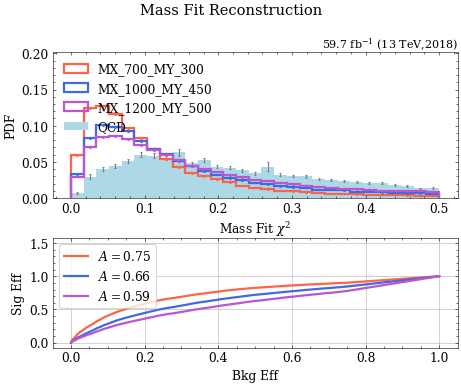

In [11]:
study.quick(
    signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['reco_rank'],
    binlist=[(0,0.5,30)],
    xlabels=['Mass Fit $\chi^2$'],
    suptitle='Mass Fit Reconstruction',
    efficiency=True,

    **study.auroc,
)

In [12]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


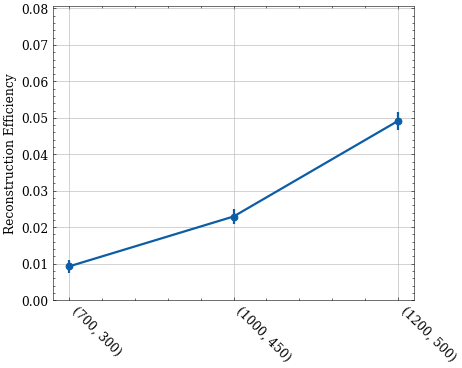

In [13]:
study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,
)

In [14]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='$M_{Y1}$ (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='$M_{Y2}$ (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='$M_{H1Y1}$ (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='$M_{H2Y1}$ (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='$M_{H1Y2}$ (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='$M_{H2Y2}$ (GeV)')


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


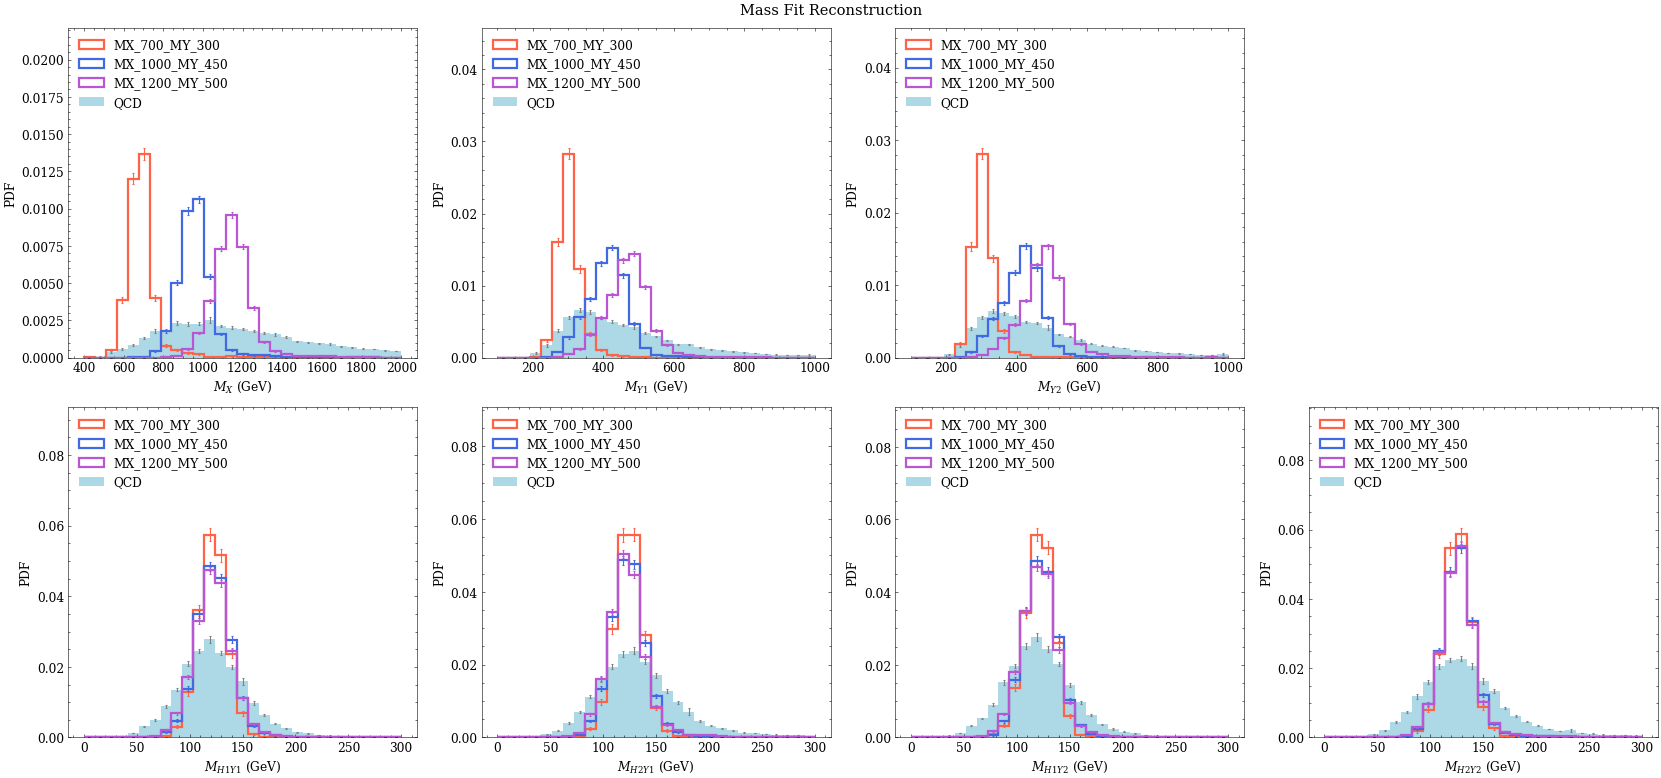

In [15]:
study.quick(
    eightb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='Mass Fit Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


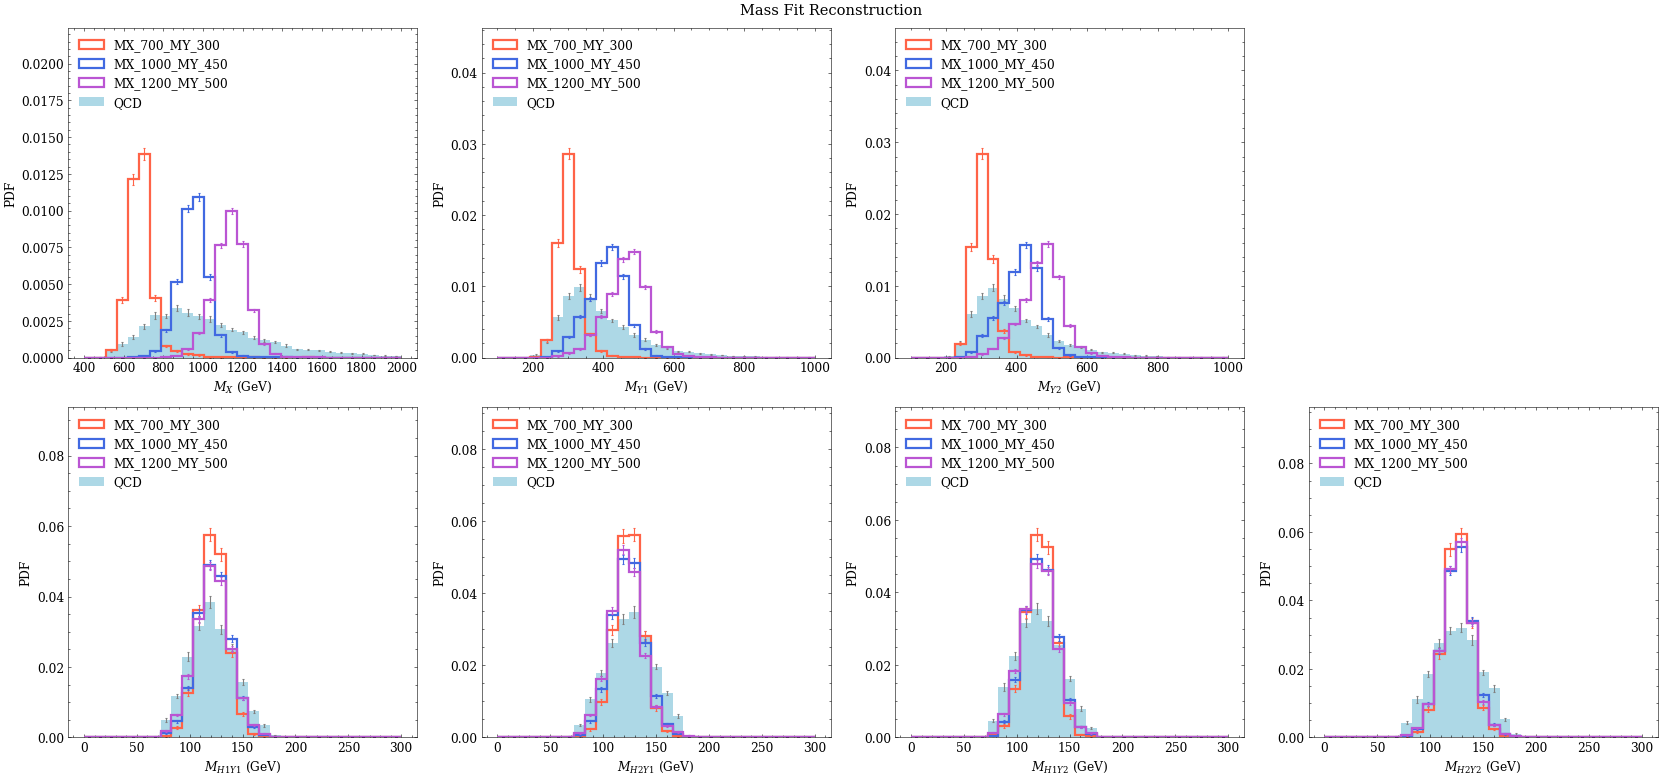

In [16]:
study.quick(
    eightb_signal+bkg,
    masks=lambda t : np.sqrt( sum((t[f'{H}_m']/125-1)**2 for H in eightb.higgslist) ) < 60/125,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='Mass Fit Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 8/8 [00:02<00:00,  3.43it/s]


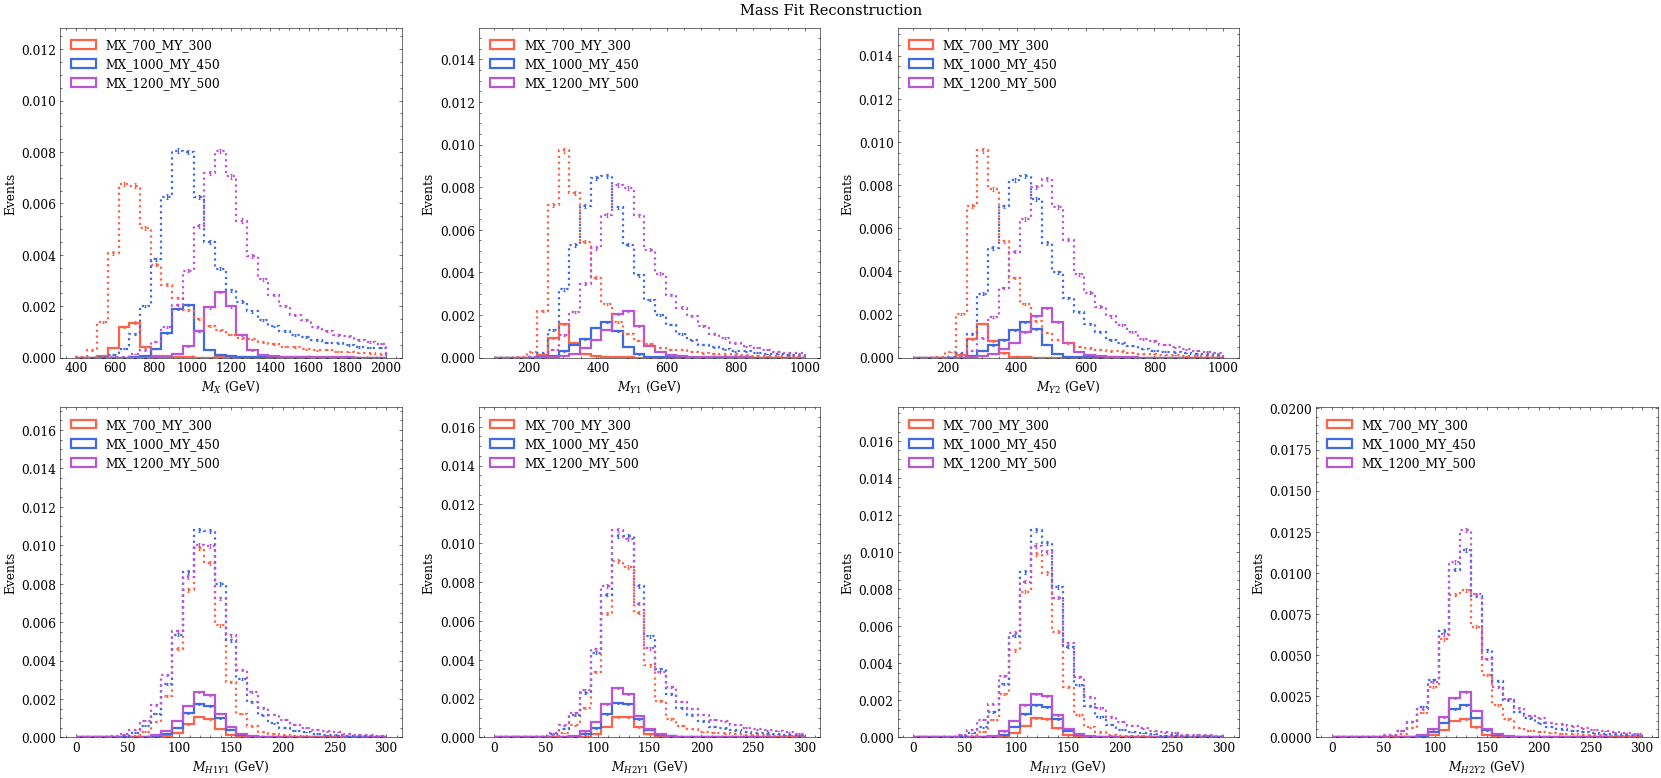

In [17]:
study.quick(
    eightb_signal+partial_signal,
    h_linestyle=['-']*len(signal)+[':']*len(signal),
    label=signal.sample.list+[None]*len(signal),
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='Mass Fit Reconstruction',
    lumi=None,
    # density=True,
)